# Multifactorial ANOVA
## 2 factors, crossed design
Reference: http://www.flutterbys.com.au/stats/tut/tut7.6b.html

In [1]:
import pandas as pd
import numpy as np
 
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import pymc3 as pm
import patsy

C:\Miniconda3\envs\GLM_with_PyMC3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Data generation

In [2]:
nA = 2  #number of levels of A
nB = 3  #number of levels of B

nsample = 50  #number of reps in each

labelsA = ['a{}'.format(i) for i in range(nA)]
labelsB = ['b{}'.format(i) for i in range(nB)]

A = np.repeat(labelsA, repeats=[nsample//nA, nsample//nA + nsample%nA])
B = np.repeat(labelsB, repeats=[nsample//nB, nsample//nB, nsample//nB + nsample%nB])

In [3]:
# cartesian product
import itertools
data = pd.DataFrame([row for row in itertools.product(labelsA, labelsB, np.arange(nsample)+1)], columns=['A', 'B', 'n'])
data.head(12)

,A,B,n
0,a0,b0,1
1,a0,b0,2
2,a0,b0,3
3,a0,b0,4
4,a0,b0,5
5,a0,b0,6
6,a0,b0,7
7,a0,b0,8
8,a0,b0,9
9,a0,b0,10


In [4]:
# Whilst the above two are equivalent for simple designs 
# (such as that illustrated), the means parameterization 
# (that does not include an intercept, or overall mean) 
# is limited to simple single factor designs. 
# Designs that involve additional predictors can only be
# accommodated via effects parameterization.

X_design = patsy.dmatrix("1 + A*B", data=data, return_type='dataframe')

X = np.asarray(X_design)
X_design.head()

,Intercept,A[T.a1],B[T.b1],B[T.b2],A[T.a1]:B[T.b1],A[T.a1]:B[T.b2]
0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0


In [5]:
np.random.seed(12345)

eff = np.array([40, 15, 5, 0, -15, 10])
sigma = 3  #residual standard deviation
eps = np.random.normal(loc=0, scale=sigma, size=X.shape[0])

y = np.dot(X, eff) + eps
data['y'] = y
data['A'] = pd.Categorical(data.A, ordered=False)
data['B'] = pd.Categorical(data.B, ordered=False)

data.shape

(300, 4)

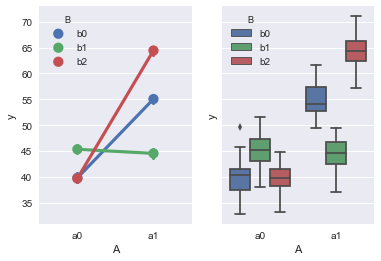

In [6]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
_ = sns.pointplot(x='A', y='y', hue='B', data=data, ax=ax[0])
_ = sns.boxplot(x='A', y='y', hue='B', data=data, ax=ax[1])

The data seems to be close to the one used in http://www.flutterbys.com.au/stats/tut/tut7.6b.html

### Bayesian modelling (Multifactorial ANOVA)
Assumption: The response variable is equally varied for each combination of treatments. (In fact, it is as we generated the data)

In [7]:
with pm.Model() as ANOVA_factorial_treatment_coding:
    
    beta = pm.Normal('beta', mu=0, sd=100, shape=(X.shape[1]))
    sd = pm.HalfCauchy('sd', beta=5)
    
    mu = pm.math.dot(X, beta)
    
    # assume same sd. How to index different sd's distributions?
    y_likelihood = pm.Normal('y_likelihood', mu=mu, sd=sd, observed=data.y)
    
    trace = pm.sample(draws=3000, step=pm.NUTS(), njobs=2, tune=1000)

C:\Miniconda3\envs\GLM_with_PyMC3\lib\site-packages\pymc3\model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd_log__, beta]


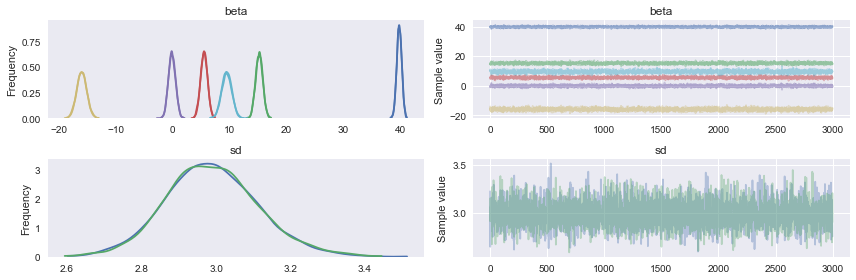

In [8]:
_ = pm.traceplot(trace)

In [9]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta__0,39.848615,0.428908,0.010474,39.043330,40.727225,1713.0,0.999868
beta__1,15.208882,0.611711,0.015076,13.984336,16.358237,1846.0,1.000085
beta__2,5.505211,0.599527,0.013600,4.288098,6.647192,1877.0,0.999913
beta__3,-0.128300,0.606566,0.013519,-1.251058,1.076284,2234.0,1.000030
beta__4,-16.007436,0.851393,0.019424,-17.738782,-14.387915,1876.0,0.999909
beta__5,9.490456,0.860345,0.018831,7.862980,11.172158,2283.0,1.000236
sd,2.987585,0.124144,0.001507,2.753940,3.247769,5109.0,0.999917


In [10]:
df_for_display = pm.summary(trace)

rows_name = X_design.design_info.column_names[:]
rows_name.append('sd')

df_for_display.index = rows_name

df_for_display

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Intercept,39.848615,0.428908,0.010474,39.043330,40.727225,1713.0,0.999868
A[T.a1],15.208882,0.611711,0.015076,13.984336,16.358237,1846.0,1.000085
B[T.b1],5.505211,0.599527,0.013600,4.288098,6.647192,1877.0,0.999913
B[T.b2],-0.128300,0.606566,0.013519,-1.251058,1.076284,2234.0,1.000030
A[T.a1]:B[T.b1],-16.007436,0.851393,0.019424,-17.738782,-14.387915,1876.0,0.999909
A[T.a1]:B[T.b2],9.490456,0.860345,0.018831,7.862980,11.172158,2283.0,1.000236
sd,2.987585,0.124144,0.001507,2.753940,3.247769,5109.0,0.999917


The parameters above are to be interpreted as:

$y = \mu_{a0b0} + \alpha_{a1} + \beta_{b1} + \beta_{b2} + \alpha_{a1}\cdot\beta_{b1} + \alpha_{a1}\cdot\beta_{b2}$

so, for example, the effect of ´a1b0´ is:

$y = 1\cdot\mu_{a0b0} + 1\cdot\alpha_{a1} + 0\cdot\beta_{b1} + 0\cdot\beta_{b2} + 1\cdot\alpha_{a1}\cdot0\cdot\beta_{b1} + 1\cdot\alpha_{a1}\cdot0\cdot\beta_{b2}$

$y = 41.488535 + 11.128384 = ~52.62$

Instead, the effect of ´a1b1´ is:

$y = 1\cdot\mu_{a0b0} + 1\cdot\alpha_{a1} + 1\cdot\beta_{b1} + 0\cdot\beta_{b2} + 1\cdot\alpha_{a1}\cdot1\cdot\beta_{b1} + 1\cdot\alpha_{a1}\cdot0\cdot\beta_{b2}$

$y = 41.488535 + 11.128384 + 3.908116 - 12.978722= ~43.54$

The results can be compared to the table below:

In [11]:
data.drop('n', axis=1).groupby(['A', 'B'], as_index=False).mean()

,A,B,y
0,a0,b0,39.844144
1,a0,b1,45.357542
2,a0,b2,39.730502
3,a1,b0,55.056000
4,a1,b1,44.567513
5,a1,b2,64.418951


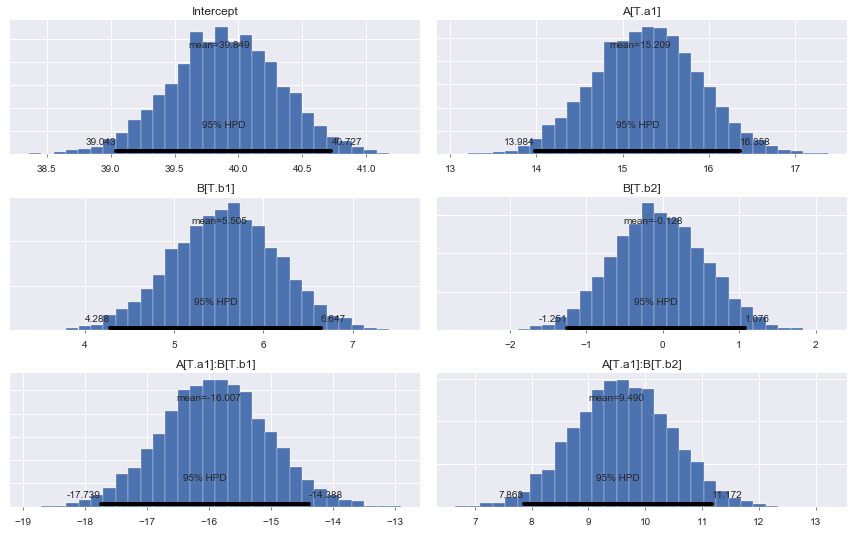

In [12]:
X_design.design_info.column_names
ax = pm.plot_posterior(trace, ['beta'])
for idx, title in enumerate(X_design.design_info.column_names):
    ax[idx].set_title(title)

### Graphical summary

In [13]:
mcmc = trace['beta']
mcmc.shape

(6000, 6)

In [14]:
newdata = pd.DataFrame([row for row in itertools.product(labelsA, labelsB)], columns=['A', 'B'])
newdata

,A,B
0,a0,b0
1,a0,b1
2,a0,b2
3,a1,b0
4,a1,b1
5,a1,b2


In [15]:
Xmat = patsy.dmatrix('A*B', newdata, return_type='dataframe')
Xmat

,Intercept,A[T.a1],B[T.b1],B[T.b2],A[T.a1]:B[T.b1],A[T.a1]:B[T.b2]
0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,1.0,0.0,0.0
3,1.0,1.0,0.0,0.0,0.0,0.0
4,1.0,1.0,1.0,0.0,1.0,0.0
5,1.0,1.0,0.0,1.0,0.0,1.0


In [16]:
fit = np.dot(np.asarray(mcmc), Xmat.T)
fit.shape

(6000, 6)

In [17]:
df_fit = newdata.copy
data_mcmc = pd.DataFrame([row for row in itertools.product(labelsA, labelsB, np.arange(mcmc.shape[0])+1)], columns=['A', 'B', 'n'])

In [18]:
data_mcmc['mcmc'] = fit.ravel(order='F')
data_mcmc.head()

,A,B,n,mcmc
0,a0,b0,1,39.545192
1,a0,b0,2,39.957793
2,a0,b0,3,39.480940
3,a0,b0,4,39.884083
4,a0,b0,5,39.735101


In [19]:
newdata['fit mean'] = fit.mean(axis=0)
newdata['sem'] = fit.std(axis=0)/np.sqrt(fit.shape[0])

newdata['conf low'] = pm.hpd(fit)[:, 0]
newdata['conf high'] = pm.hpd(fit)[:, 1]

newdata

,A,B,fit mean,sem,conf low,conf high
0,a0,b0,39.848615,0.005537,39.043330,40.727225
1,a0,b1,45.353827,0.005377,44.521149,46.147865
2,a0,b2,39.720315,0.005523,38.876279,40.562790
3,a1,b0,55.057498,0.005376,54.237933,55.859520
4,a1,b1,44.555273,0.005515,43.732810,45.396137
5,a1,b2,64.419653,0.005485,63.540319,65.214616


In [20]:
df_check_fit = data.drop('n', axis=1).groupby(['A', 'B'], as_index=False).mean()

In [21]:
df_check_fit['fit'] = newdata['fit mean']
df_check_fit['error fit'] = df_check_fit['y'] - df_check_fit['fit']
df_check_fit

,A,B,y,fit,error fit
0,a0,b0,39.844144,39.848615,-0.004471
1,a0,b1,45.357542,45.353827,0.003716
2,a0,b2,39.730502,39.720315,0.010187
3,a1,b0,55.056000,55.057498,-0.001498
4,a1,b1,44.567513,44.555273,0.012240
5,a1,b2,64.418951,64.419653,-0.000703


In [22]:
with ANOVA_factorial_treatment_coding:
    sample_ppc = pm.sample_ppc(trace)

100%|████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:01<00:00, 2115.63it/s]


In [23]:
data_ppc = pd.DataFrame([row for row in itertools.product(labelsA, 
                                                          labelsB, 
                                                          np.arange(sample_ppc['y_likelihood'].shape[0]*nsample)+1)], 
                        columns=['A', 'B', 'n'])
data_ppc.shape

(900000, 3)

In [24]:
data_ppc['y'] = np.asarray(sample_ppc['y_likelihood']).ravel(order='F')

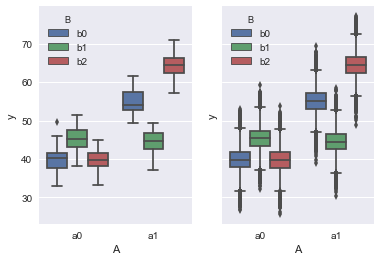

In [25]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
_ = sns.boxplot(x='A', y='y', hue='B', data=data, ax=ax[0])
_ = sns.boxplot(x='A', y='y', hue='B', data=data_ppc, ax=ax[1])